# Support Vector Machine

In [9]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import pickle
from src.train_test import *
from src.preprocessor import *
from src.assess import *

In [2]:
# Read, split, and transform the data

data = pd.read_csv('smog_data_cleaned.csv')
X_train, X_test, y_train, y_test = split(data)
preprocessor = preprocesser()

In [3]:
pipe_svc = make_pipeline(preprocessor, SVC(probability=True))
pipe_opt_svc = GridSearchCV(pipe_svc, param_grid = {
    "svc__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "svc__gamma": [0.001, 0.01, 0.1, 1, 10, 100],
}, cv=3)
pipe_opt_svc.fit(X_train, y_train);

In [4]:
best_para = pipe_opt_svc.best_params_
print(best_para)

{'svc__C': 10, 'svc__gamma': 0.1}


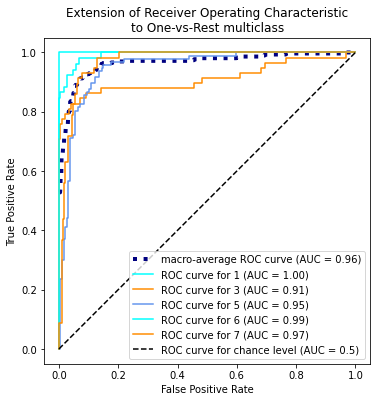

In [5]:
svc_cv = cv_predict_interval(pipe_opt_svc, X_train, y_train)
mean_cv_svc = get_mean_cv(svc_cv)
result_svc = mean_std_cross_val_scores(pipe_opt_svc, X_train, y_train,return_train_score=True,scoring='accuracy')
misClassificationRate_svc = calc_misclass_rate_pred_interval(pipe_opt_svc.predict_proba(X_test),y_test)
test_score_svc = pipe_opt_svc.score(X_test, y_test)
auc_svc = auc_drawer(pipe_opt_svc, X_test, y_train,y_test)
auc_svc = list(auc_svc.values())
roc_svc = roc_auc_score(y_test, pipe_opt_svc.predict_proba(X_test), multi_class='ovr')

cm_svc = confusion_matrix(y_test, pipe_opt_svc.predict(X_test))
cm_svc = cm_svc.diagonal()/cm_svc.sum(axis=1)
cm_svc = cm_svc.tolist()

In [6]:
cv_tb = cv_result_table(svc_cv, mean_cv_svc, result_svc['test_score'],result_svc['train_score'])
test_tb = get_test_result_table(misClassificationRate_svc, cm_svc, test_score_svc, auc_svc, roc_svc).round(4)

print(cv_tb)
print(test_tb)

                    1      2      3      4      5               mean
pred50           0.12  0.165  0.159  0.136  0.167               0.15
pred80          0.053  0.083  0.061  0.068  0.076              0.068
Train_Accuracy      -      -      -      -      -  0.971 (+/- 0.012)
Test_Accuracy       -      -      -      -      -  0.819 (+/- 0.032)
                 1      3      5      6      7  Overall
class_pred50  0.10  0.207  0.113  0.077  0.228    0.145
class_pred80  0.00  0.138  0.031  0.019  0.088    0.055
Accuracy      0.95  0.793  0.876  0.923  0.737    0.845
AUC           1.00  0.912  0.950  0.993  0.969    0.965


In [10]:
with open('workspace_file/03e_1_svc_cv.pkl', 'wb') as f:
    pickle.dump(cv_tb, f)
    
with open('workspace_file/03e_2_svc_test.pkl', 'wb') as f:
    pickle.dump(test_tb, f)